<a href="https://www.kaggle.com/code/irfandahusnisahid/time-series-forecasting-using-arima?scriptVersionId=117574644" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Time Series Forecasting using ARIMA 

This notebook discussed about ARIMA model forecasting. The data used in this notebook was BBCA.JK stocks (Bank Central Asia). Classic ARIMA modelling process were performed to find p,d,and q variables. 

The goal of this notebook is to find Root Mean Squared Error value for ARIMA model by forecasting the closing price one-day ahead. This RMSE then compared with the naive approach (Using the same value as the previous day)


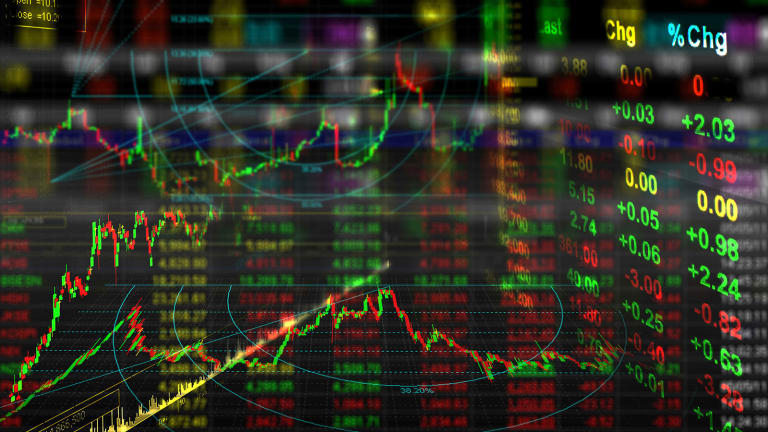

Let's first install the required library. Yahoo finance is used to get the price data.

## 1. Libraries

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 672.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.2 which is incompatible.
ibis-framework 2.1.1 requires importlib-metadata<5,>=4; python_version < "3.8", but you have importlib-metadata 6.0.0 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which 

In [2]:
import warnings 
import datetime
import numpy as np
import pandas as pd 
import seaborn as sns 
import yfinance as yf
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

## 2. Function

In [3]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Test Result")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

## 3. Dataset

Get the data by using yahoo finance API using the code BBCA.JK, then sample the data from 2015 to 2023 and remove the timezone datetime property. Then we examine the data. 

In [4]:
#Dataset
data = yf.download("BBCA.JK", start="2015-01-01", end="2023-01-31")
data = data.reset_index()
data['Date'] = data['Date'].dt.tz_localize(None)
print(data.info())
print("Data shape: ",np.shape(data))
data.head()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2018 non-null   datetime64[ns]
 1   Open       2018 non-null   float64       
 2   High       2018 non-null   float64       
 3   Low        2018 non-null   float64       
 4   Close      2018 non-null   float64       
 5   Adj Close  2018 non-null   float64       
 6   Volume     2018 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 110.5 KB
None
Data shape:  (2018, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,2655.0,2655.0,2630.0,2645.0,2358.199463,29302500
1,2015-01-05,2630.0,2640.0,2625.0,2640.0,2353.740967,25434500
2,2015-01-06,2600.0,2640.0,2600.0,2620.0,2335.909912,48681500
3,2015-01-07,2610.0,2640.0,2610.0,2625.0,2340.367676,40334000
4,2015-01-08,2625.0,2630.0,2595.0,2595.0,2313.620605,54457000


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2.018000e+03
mean,5085.849851,5133.151635,5038.037661,5085.820119,4834.955556,8.211994e+07
std,1844.324229,1862.816637,1826.691938,1845.715236,1902.328839,5.510048e+07
min,2275.000000,2350.000000,2200.000000,2260.000000,2028.285522,0.000000e+00
25%,3100.000000,3120.000000,3085.000000,3100.000000,2830.524170,5.286025e+07
50%,5127.500000,5202.500000,5082.500000,5165.000000,4826.263672,7.198910e+07
75%,6463.750000,6511.250000,6380.000000,6440.000000,6243.853516,9.977650e+07
max,9275.000000,9400.000000,9000.000000,9300.000000,9263.833008,1.062862e+09


In [6]:
print("Earliest date :",data["Date"].min())
print("Latest date :",data["Date"].max())

Earliest date : 2015-01-02 00:00:00
Latest date : 2023-01-27 00:00:00


### 3.1 Train Test Split 
After examine the data, we split the data into train and test data. The train data is starting from 2015 to June 2022, and the test data is starting from June 2022 to January 2023.

In [7]:
train_data = data[data["Date"] < datetime.datetime(2022,6,1)]
test_data = data[data["Date"] >= datetime.datetime(2022,6,1)]

## 4. Modelling ARIMA 

Having split our dataset, now it's the turn to find the p,d,q of our ARIMA model. The explanation of ARIMA variables is available in [here](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/).

</br>
<h3>4.1 Finding d value</h3>
First we want to find the order of differencing (d) in our model. First, let's see the PACF (Partial AutoCorrelation) plot for our data.

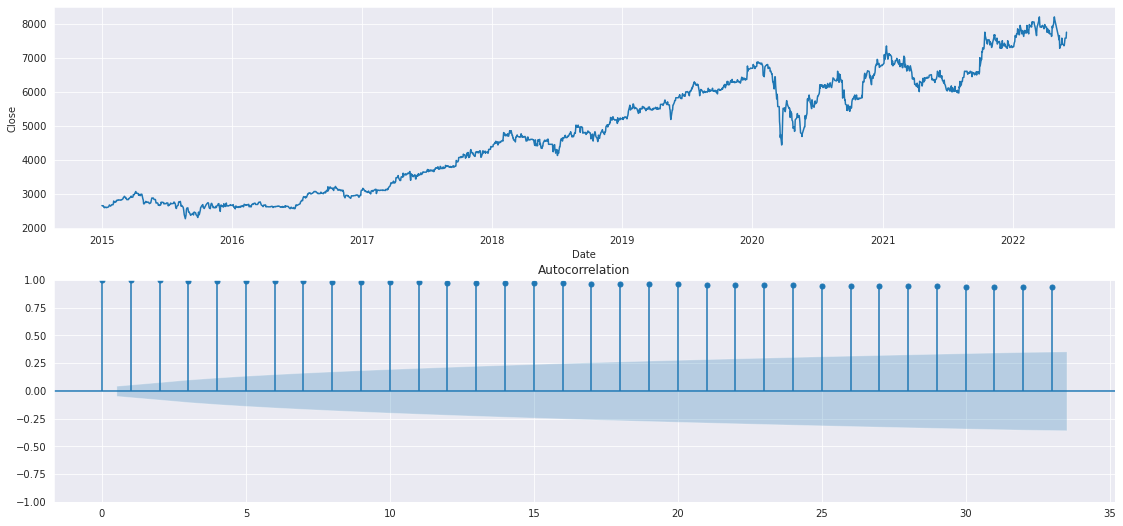

ADF Test Result
ADF Statistic: -0.428685
p-value: 0.905198
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [8]:
fig,ax = plt.subplots(2,1,figsize=(16,8))
fig.tight_layout(pad=3.0)
sns.lineplot(x="Date",y="Close",data=train_data, ax=ax[0])
plot_acf(train_data.Close, ax=ax[1])
plt.show()
adf_test(train_data.Close)

Here we can see that the PACF lags are higher than the threshold (blue region). This means that we need to difference our data. ADF test also stating that we need to difference our data since p-values > 0.05. Let's try to difference with order = 1.

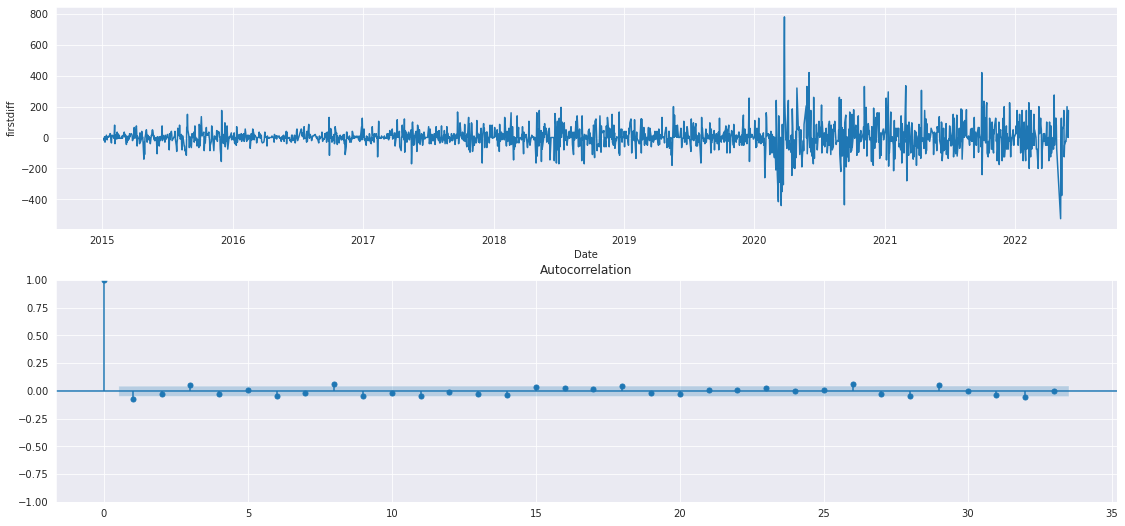

ADF Test Result
ADF Statistic: -14.351226
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [9]:
#1st Order Differencing 
train_data["firstdiff"] = train_data.Close.diff()
fig,ax = plt.subplots(2,1,figsize=(16,8))
fig.tight_layout(pad=3.0)
sns.lineplot(x="Date",y="firstdiff",data=train_data, ax=ax[0])
plot_acf(train_data.firstdiff.dropna(), ax=ax[1])
plt.show()
adf_test(train_data.firstdiff.dropna())

Here we can see that the p-value < 0.05 meaning we get a significant value (thus no need to differencing more). The PACF lags also roughly stayed in the blue region. Hence we can temporary conclude that d = 1. 
<br>
<h3>4.2 Finding p value</h3>
The next step is to find the p value of ARIMA. We can determine the variable by plotting ACF value and see whether the lags are staying in the blue region. <br>
Here we plot the ACF correlation with the first difference value : 

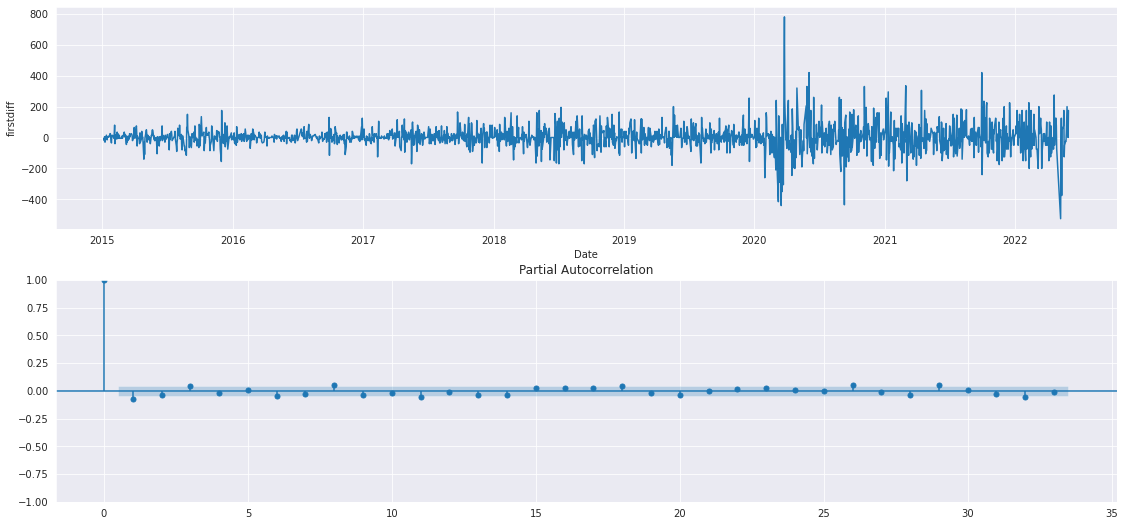

In [10]:
#1st Order Differencing 
fig,ax = plt.subplots(2,1,figsize=(16,8))
fig.tight_layout(pad=3.0)
sns.lineplot(x="Date",y="firstdiff",data=train_data, ax=ax[0])
plot_pacf(train_data.firstdiff.dropna(), ax=ax[1])
plt.show()

From the ACF plot, we can see that the lags are roughly staying in the blue region, meaning that we can temporary conclude that the p value = 1. 
<br>
<h3> 4.3 Finding Q value </h3>
The final variable of ARIMA is q. We can determine this value by plotting PACF. The plot of PACF with the first order differencing can be seen below. 

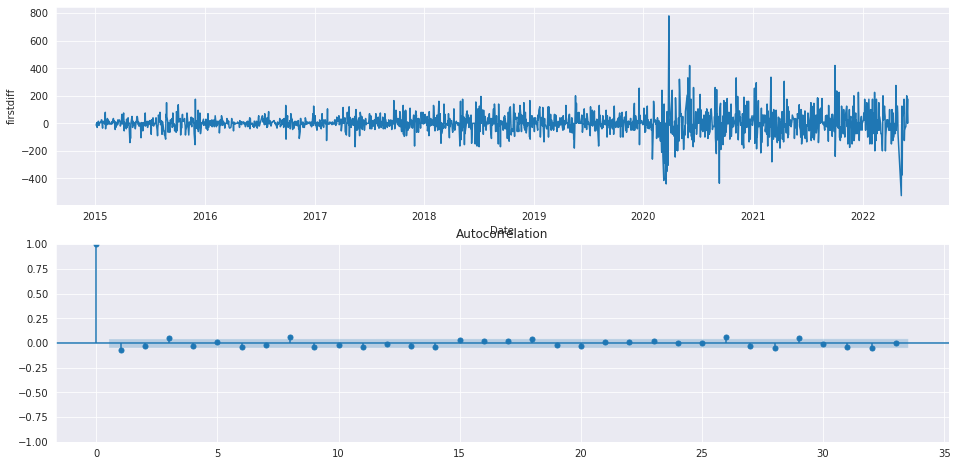

In [11]:
#1st Order Differencing 
fig,ax = plt.subplots(2,1,figsize=(16,8))
sns.lineplot(x="Date",y="firstdiff",data=train_data, ax=ax[0])
plot_acf(train_data.firstdiff.dropna(), ax=ax[1])
plt.show()

From the figure above, we can see that the lags are roughly staying in the blue region, meaning that we can temporary conclude the q value = 1.

<h3>4.4 Fitting Model</h3>
After finding p,d,q values, we can continue to model ARIMA using the values of (1,1,1).

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1848
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10637.372
Date:                Sat, 28 Jan 2023   AIC                          21280.744
Time:                        20:31:16   BIC                          21297.308
Sample:                             0   HQIC                         21286.851
                               - 1848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1237      0.176      0.702      0.483      -0.222       0.469
ma.L1         -0.1980      0.174     -1.139      0.255      -0.539       0.143
sigma2      5901.1195     79.748     73.997      0.0

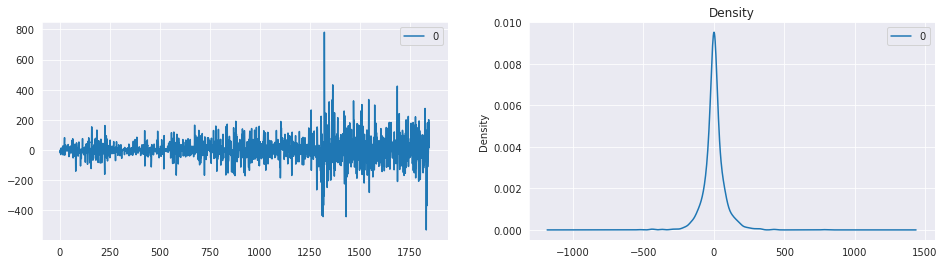

In [12]:
# ARIMA Model
model = ARIMA(train_data.Close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

fig,ax = plt.subplots(1,2,figsize=(16,4))
residuals = pd.DataFrame(model_fit.resid)
residuals = residuals.iloc[1:]
residuals.plot(ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The summary shown that the P > |z| values for AR and MA are > 0.05. This means that we need to reconfigure the p,d,q variables. Let's try to difference even more with d = 2.

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1848
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -10634.989
Date:                Sat, 28 Jan 2023   AIC                          21275.977
Time:                        20:31:17   BIC                          21292.540
Sample:                             0   HQIC                         21282.083
                               - 1848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0723      0.015     -4.811      0.000      -0.102      -0.043
ma.L1         -0.9999      0.024    -42.439      0.000      -1.046      -0.954
sigma2      5886.4051    178.162     33.040      0.0

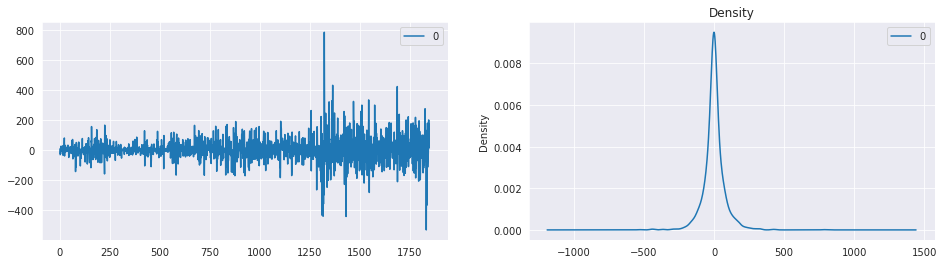

In [13]:
# ARIMA Model
model = ARIMA(train_data.Close, order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())

fig,ax = plt.subplots(1,2,figsize=(16,4))
residuals = pd.DataFrame(model_fit.resid)
residuals = residuals.iloc[2:]
residuals.plot(ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Here we can see that tha p values are < 0.05 across all variables, also the residual KDE plot has a mean value near 0. 

## 5. Out of Sample Forecast
Now let's forecast the stock values using ARIMA one-day ahead and rolling the forecast for about 6 months. 

In [14]:
pred_result = []
for i in range(len(test_data)):
    model = ARIMA(data.iloc[:(len(train_data) + i)].Close, order=(1,1,1))
    model_fit = model.fit()
    predicted = model_fit.forecast(1)
    pred_result.append(predicted.values[0])
test_data["predicted"] = pred_result

As a baseline, we can use naive prediction (the value of the date <i>t</i> is the same as the value yesterday (<i>t-1</i>).

In [15]:
test_data["naive_predicted"] = test_data.Close.shift(1)
test_data["naive_predicted"].iloc[0] = train_data.Close.iloc[-1]

Finally we can compare the result of the ARIMA model against naive model and the actual values. 

Naive predicted RMSE :  13073.529411764706
ARIMA predicted RMSE :  12766.823181459215


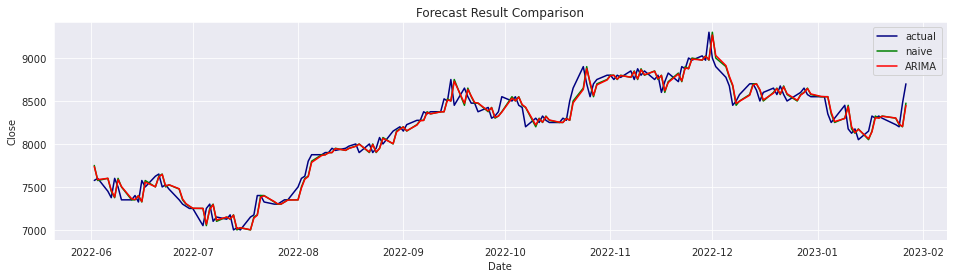

In [16]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
ax.set_title("Forecast Result Comparison")
sns.lineplot(x="Date",y="Close",data=data.iloc[-(len(test_data)):],ax=ax, color="navy")
sns.lineplot(x="Date",y="naive_predicted",data=test_data,ax=ax,color="green")
sns.lineplot(x="Date",y="predicted",data=test_data,ax=ax,color="red")
plt.legend(["actual","naive","ARIMA"])
print("Naive predicted RMSE : ",mean_squared_error(test_data.Close, test_data.naive_predicted, squared=True))
print("ARIMA predicted RMSE : ",mean_squared_error(test_data.Close, test_data.predicted, squared=True))

Here we can see that the RMSE of ARIMA (12766) is lower than naive prediction (13073), although by not much. 

Reference
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- https://machinelearningmastery.com/time-series-data-stationary-python/
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://otexts.com/fpp2/residuals.html